In [1]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize
import datetime

%matplotlib inline

# Core Functions

The functions below form the core of the simulation. Note that we haven't bothered to write a function for computing magnetization, because the magnetization is just the sum of the spins on the lattice.

In [2]:
# assumes periodic BCs
# boltz is a dictionary of the relevant boltzmann factors, with keys given by the possible magnitudes 
#    of the sum of the surrounding spins; on a 2D square lattice, there are only 2
def metropolis_ising(init, boltz):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, 
    and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # applying the Metropolis algorithm
    spin_sum = (mesh[(y+1) % Y,x ] + mesh[y ,(x+1) % X] + mesh[(y-1) % Y,x ] + mesh[y ,(x-1) % X])
    d_energy = 2*mesh[y,x] * spin_sum
    
    if d_energy <= 0:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    else:
        d_energy = 0
        d_mag = 0
        

    return [mesh, d_energy, d_mag]



def mc_sweep(init, boltz):
    """Evolves a grid for one sweep using the Metropolis algorithm"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    # just applies the metropolis algorithm X*Y times
    for j in range(X):
        for i in range(Y):
            x = np.random.randint(X)
            y = np.random.randint(Y)
            spin = grid[y,x]
            
            spin_sum = grid[(y+1) % Y,x ] + grid[y ,(x+1) % X] + grid[(y-1) % Y,x ] + grid[y ,(x-1) % X]
            d_energy = 2 * spin * spin_sum

            if d_energy <= 0:
                grid[y,x] = -1*grid[y,x]

            elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
                grid[y,x] = -1*grid[y,x]
        
    return grid
                

In [3]:
def plot_ising_grid(init, title):
    """Creates a discrete colormap for an input Ising grid, red for up (1) and blue for down (-1)"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(6,6))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    display.clear_output(wait = True)

    plt.show()

### Convenience functions

In [5]:
def mc_sweep(init, boltz):
    """Evolves an Ising grid by one sweep with the Metropolis algorithm"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            x = np.random.randint(X)
            y = np.random.randint(Y)
            spin = grid[y,x]
            
            spin_sum = grid[(y+1) % Y,x ] + grid[y ,(x+1) % X] + grid[(y-1) % Y,x ] + grid[y ,(x-1) % X]
            d_energy = 2 * spin * spin_sum

            if d_energy <= 0:
                grid[y,x] = -1*grid[y,x]

            elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
                grid[y,x] = -1*grid[y,x]
        
    return grid



def mult_sweeps(init, boltz, N):
    """Just a looping function for mc_sweep for convenience"""
    
    grid = copy.copy(init)
    
    for n in range(N):
        grid = mc_sweep(grid, boltz)
        
    return grid    

# Measurements

In [4]:
def ising_energy(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += -1 * init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
    
    # divide by 2 because we overcount every bond twice
    energy = energy/2
    
    return energy


def energy_evo(init, boltz, n, plot = True):
    """Returns a list of energies for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # energy
    energy = ising_energy(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(n):
        grid, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment energy
        energy += d_energy
        energy_list.append(energy)

    
    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list


def magps(init, boltz, n, plot = True):
    """Returns a list of mag. per spin for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # magnetization
    mag = np.sum(grid)
    mag_list = [mag/total]
    
    # evolution
    for i in range(n):
        grid, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment magnetization
        mag += d_mag
        mag_list.append(mag/total)

    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,mag_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Magnetization per Spin', fontsize=20)
        plt.title(f'Magnetization per Spin of Ising Grid', fontsize=20)
    
    
    return mag_list

# Derived Measurements

The following functions compute various thermodynamic quantities based on a given input of measured values.

In [5]:
def spec_heat_ps(energy_list, T, N):
    """Compute the specific heat per spin for an input list of energy values at temperature T and lattice sites N"""

    c = (1/(T**2 * N)) * np.var(energy_list)
    
    return c



def sus(mag_list, T, N):
    """Compute the magnetic susceptibility for an input list of magnetization values at temperature T 
       and lattice sites N"""

    chi = (1/(T*N)) * np.var(mag_list)
    
    return chi



def ss_cor(init, boltz, n_sweep, n_equil, s1, s2):
    """Compute the mean correlation between spins s1 and s2, which are should be a tuple of indices denoting
       their location on the lattice, e.g. s1 = (33, 22)"""
    
    grid = copy.copy(init)
    
    cor = 0
    
    # evolve for a given amount of steps before taking measurements
    for i in range(n_equil):
        grid = sweep(grid, boltz)
        
    # making measurements once every sweep
    for j in range(n_sweep):
        grid = mc_sweep(grid, boltz)
        cor += grid[s1[0],s1[1]] * grid[s2[0],s2[1]]
    
    # normalizing    
    cor = cor/(n_sweep)
    
    return cor

# Error Functions

In [12]:
def bootstrap_mean(values, n):
    """Uses the bootstrap method iterated n times to compute the error in the mean of a given list of values"""

    ns = len(values)
    
    means = np.zeros(n)
    
    # sample the list n times
    for i in range(n):
        samples = np.random.choice(values, ns)
        means[i] = np.mean(samples)
    
    error = np.std(means)
    
    return error
    
    
def bootstrap_c(energies, T, N, n):
    """Uses the bootstrap method iterated n times to compute the error in the specific heat for an 
       input list of energies"""

    ns = len(energies)
    
    values = np.zeros(n)
    
    # sample the energies n times
    for i in range(n):
        samples = np.random.choice(energies, ns)
        values[i] = spec_heat_ps(samples, T, N)
        
    error = np.std(values)
    
    return error


def bootstrap_s(magps, T, N, n):
    """Uses the bootstrap method iterated n times to compute the error in the susceptibility for 
       an input list of magnetizations"""
    
    ns = len(magps)
    
    values = np.zeros(n)
    
    # sample the magnetizations n times
    for i in range(n):
        samples = np.random.choice(magps, ns)
        values[i] = sus(samples, T, N)
    
    error = np.std(values)
    
    return error
        

# Example: Equilibrium Plots

Formally, the functions energy_evo and magps can produce such plots, but I want to record the energy and magnetization for the same grid for its entire evolution, which those functions cannot do. Plus I can manually set the checkpoint time this way.

In [88]:
L = 100
initial = np.ones((L,L))
x_axis = np.arange(0, L*L*1000, 100)/10000

T = 2.6
test_boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}

In [89]:
grid = copy.copy(initial)

# initialize the energy and magnetization lists
energy = ising_energy(grid)
mag = np.sum(grid)

energy_list = np.zeros(L*L*1000)
mag_list = np.zeros(L*L*1000)

start = time.time()


for i in range(L*L*1000):
    grid, d_energy, d_mag = metropolis_ising(grid, test_boltz)
    energy += d_energy
    mag += d_mag
    
    # faster if there is an interval between measurements
    if ((i+1) % 100) == 0:
        energy_list[i] = energy
        mag_list[i] = mag
    
    # checkpointing    
    if ((i+1) % 1000000) == 0:
        tick = time.time()
        print(f'Sweep {(i+1)/10000}; {tick-start} seconds')

# normalize
energy_list = energy_list/10000
mag_list = mag_list/10000
    

Sweep 100.0; 13.384894847869873 seconds
Sweep 200.0; 26.51073431968689 seconds
Sweep 300.0; 39.698837757110596 seconds
Sweep 400.0; 52.793232679367065 seconds
Sweep 500.0; 66.32531523704529 seconds
Sweep 600.0; 79.51348924636841 seconds
Sweep 700.0; 92.62358975410461 seconds
Sweep 800.0; 105.78056406974792 seconds
Sweep 900.0; 118.96873927116394 seconds
Sweep 1000.0; 132.11023712158203 seconds


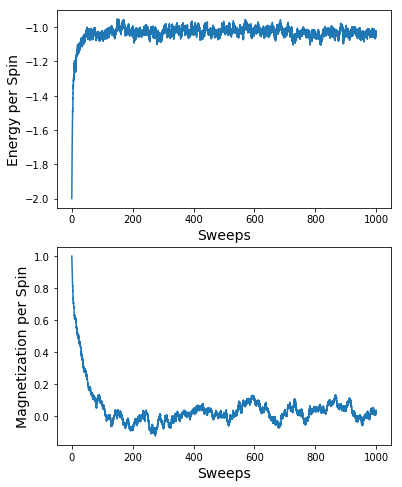

In [13]:
fig = plt.figure(figsize=(6, 8)) 

fig.add_subplot(2, 1, 1 )
plt.plot(x_axis, energy_list)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Sweeps', fontsize=14)
plt.ylabel('Energy per Spin', fontsize=14)

fig.add_subplot(2, 1, 2 )
plt.plot(x_axis, mag_list)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Sweeps', fontsize=14)
plt.ylabel('Magnetization per Spin', fontsize=14)

# Example: Lattices at Different Temperature

In [14]:
boltzlist = [{"4.0" : np.exp(-8/.01), "2.0" : np.exp(-4/.01)},{"4.0" : np.exp(-8/2), "2.0" : np.exp(-4/2)},
            {"4.0" : np.exp(-8/3), "2.0" : np.exp(-4/3)}, {"4.0" : np.exp(-8/100), "2.0" : np.exp(-4/100)}]

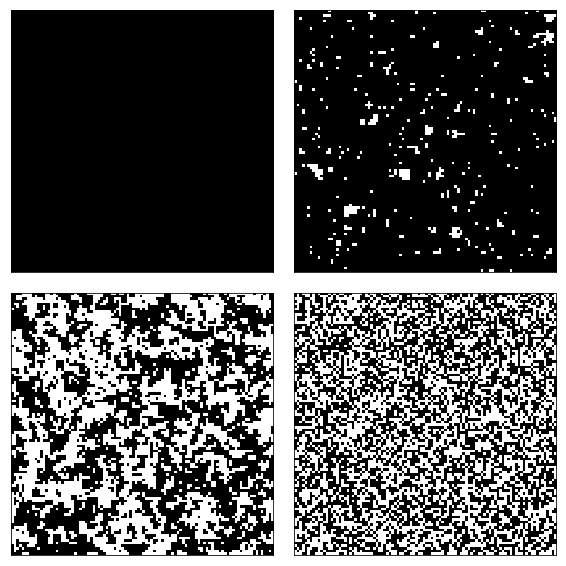

In [23]:
f, axes = plt.subplots(2,2)
f.set_size_inches(8,8)
plt.tight_layout(pad=0, w_pad=-1, h_pad=-1)

cmap = colors.ListedColormap(['white', 'black'])
bounds = [0,1,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

axarr = np.ndarray.flatten(axes)

for ax, num in zip(axarr, range(4)):
    output = mult_sweeps(ones, boltzlist[num], 500)
    ax.imshow(output, cmap=cmap, norm=norm)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
#plt.savefig('4 Temps.pdf', bbox_inches='tight')

# Example: Lattice evolution

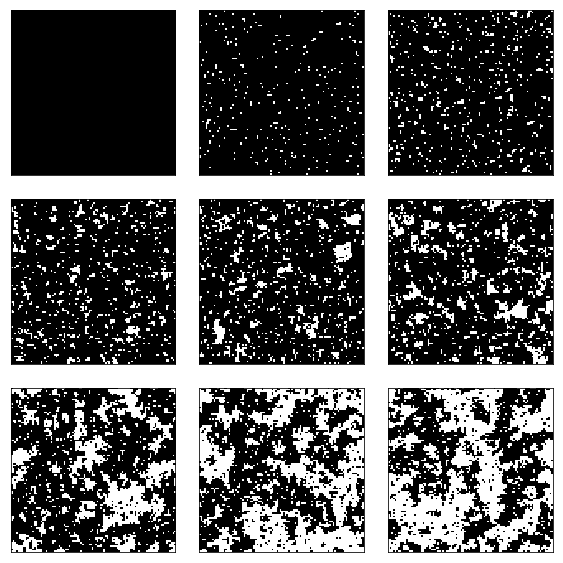

In [139]:
f, axes = plt.subplots(3,3)
f.set_size_inches(8,8)
plt.tight_layout(pad=0, w_pad=-1, h_pad=-1)

cmap = colors.ListedColormap(['white', 'black'])
bounds = [0,1,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

axarr = np.ndarray.flatten(axes)
numsweeps = [0, 1,5,10,20,50,100, 500,1000] 

for ax, num in zip(axarr, numsweeps):
    output = mult_sweeps(ones, test_boltz, num)
    ax.imshow(output, cmap=cmap, norm=norm)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
# plt.savefig('Lattice evolution.pdf', bbox_inches='tight')

# Example: Getting Data and Measurements

In [7]:
# just for convenience
def round_to_3(x):
    if x != 0:
        return round(x, -int(np.floor(np.log10(abs(x)))) + 2)
    else:
        return 0

In [8]:
# lattice size
L = 10

# initialize to T = 0
initial = 1*np.ones((L,L)) 

# specify the temperature range and resolution to be explored
temps = [t for t in np.arange(1.6, 2.91, .01)]
t_points = len(temps)


# for convenience when turning them into keys
for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    

# initialize dictionaries to store all measured values for error purposes
energy_dict = {}
mag_dict = {}

# set up keys and entries for dictionary
for T in temps:
    energy_dict[str(T)] = []
    mag_dict[str(T)] = []
    
# initialize lists of means and derived measurements
eneps_list = np.zeros(t_points)
magps_list = np.zeros(t_points)
spec_heat = np.zeros(t_points)
mag_sus = np.zeros(t_points)


# equilibration time in sweeps
n_eq = 75*L

# number of measurements to make, separated by 1 sweep
n = 75*L

# factors for averaging
n1 = 1/(n * L**2)
n2 = 1/(n**2 * L**2)

In [9]:
# run the simulation!

print(datetime.datetime.now().time())
start = time.time()

grid = copy.copy(initial)

# at every temperature in temps, the grid is evolved for n_eq sweeps, then makes n measurements of the 
# energy and magnetization, with each measurement separated by 1 sweep
for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    
    # starts from the final state of the previous temperature to improve equililbration
    for j in range(n_eq):
        grid = mc_sweep(grid, boltz)           
    
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    
    # dummy lists to hold the measurements
    e_all = np.zeros(n)
    m_all = np.zeros(n)
    
    
    # taking measurements
    for k in range(n):
        grid = mc_sweep(grid, boltz)            
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += abs(mag)
        mag2_total += mag*mag
        
        e_all[k] = energy
        m_all[k] = abs(mag)
    
    
    # storing all measurements for error purposes    
    energy_dict[str(T)] = e_all
    mag_dict[str(T)] = m_all
    
    
    # compute averages
    eneps_list[i] = n1*e_total
    magps_list[i] = n1*mag_total
    spec_heat[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
    
    
    # manually setting checkpoints to track the progress and time of the simulation
    if (1.599 < T < 1.601) or (1.899 < T < 1.901) or (2.199 < T < 2.201) or (2.499 < T < 2.501):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(f'Total time: {end - start}')   

21:34:16.330330
T = 1.6; 0.9414072036743164 seconds
T = 1.9; 28.84387707710266 seconds
T = 2.2; 55.82229924201965 seconds
T = 2.5; 82.11475396156311 seconds
Total time: 117.3605010509491


Text(0,0.5,'Susceptibility')

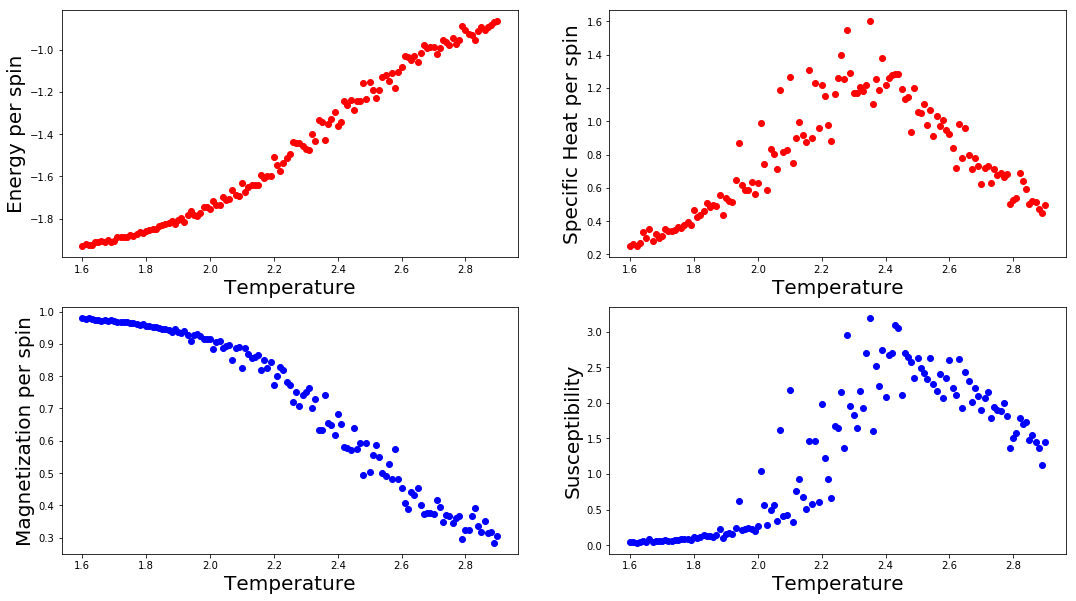

In [10]:
# plot the measurements

fig = plt.figure(figsize=(18, 10))  

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

# Example: Computing Errors
Uses the values from the run above to compute errors

In [13]:
keys = list(mag_dict.keys())

mag_errors = []

for k in keys:
    mag_errors.append(bootstrap_mean(mag_dict[k], 1000))
    
mag_errors = np.array(mag_errors)/(L*L)

################################################

sus_errors = []

for k in keys:
    sus_errors.append(bootstrap_s(mag_dict[k], float(k), L*L, 1000))
    
################################################

sh_errors = []

for k in keys:
    sh_errors.append(bootstrap_c(energy_dict[k], float(k), L*L, 1000))
    
#################################################

ene_errors = []

for k in keys:
    ene_errors.append(bootstrap_mean(energy_dict[k], 1000))
    
ene_errors = np.array(ene_errors)/(L*L)

# Example: Fitting Lines for Critical Exponents
Here I just directly show the work done to fit the curve for the magnetization on a 50 by 50 lattice, i.e. the plot on the report. 10 by 10 lattices aren't great here, needless to say. We simply repeat the same procedure for the other critical exponents.

In [14]:
def power(x, a, b, c):
    return a*((b-x)/b)**c


def powerpos(x, a, b, c):
    return a*((x-b)/b)**c

Text(0,0.5,'Magnetization')

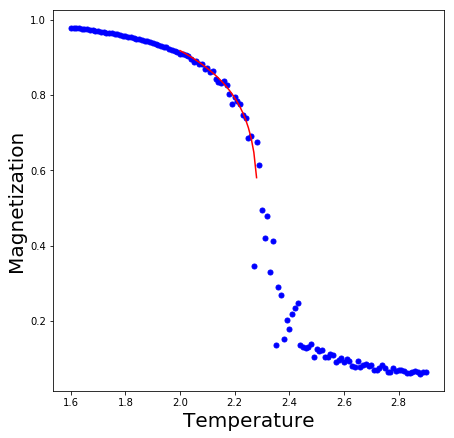

In [491]:
plt.figure(figsize=(7,7)) 
plt.plot(temps, magps_list, 'bo', markersize = 5)
plt.plot(temps[40:69], f_m, 'r')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization", fontsize=20)

In [499]:
scipy.optimize.curve_fit(power, temps[50:67], magps_list[50:67], p0 = [1, 2.35, 0.125], sigma = mag_errors[50:67], maxfev=10000)

C:\Users\Newton\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


(array([1.18568553, 2.28694199, 0.12320771]),
 array([[0.00256788, 0.00058717, 0.00095961],
        [0.00058717, 0.00015994, 0.00022848],
        [0.00095961, 0.00022848, 0.00036243]]))

In [ ]:
# extended the function beyond the fit points so that it can be seen more easily against the data
f_m = [power(x, 1.18568553, 2.28694199, 0.12320771) for x in temps[40:69]]

# Example: Generating the final plot

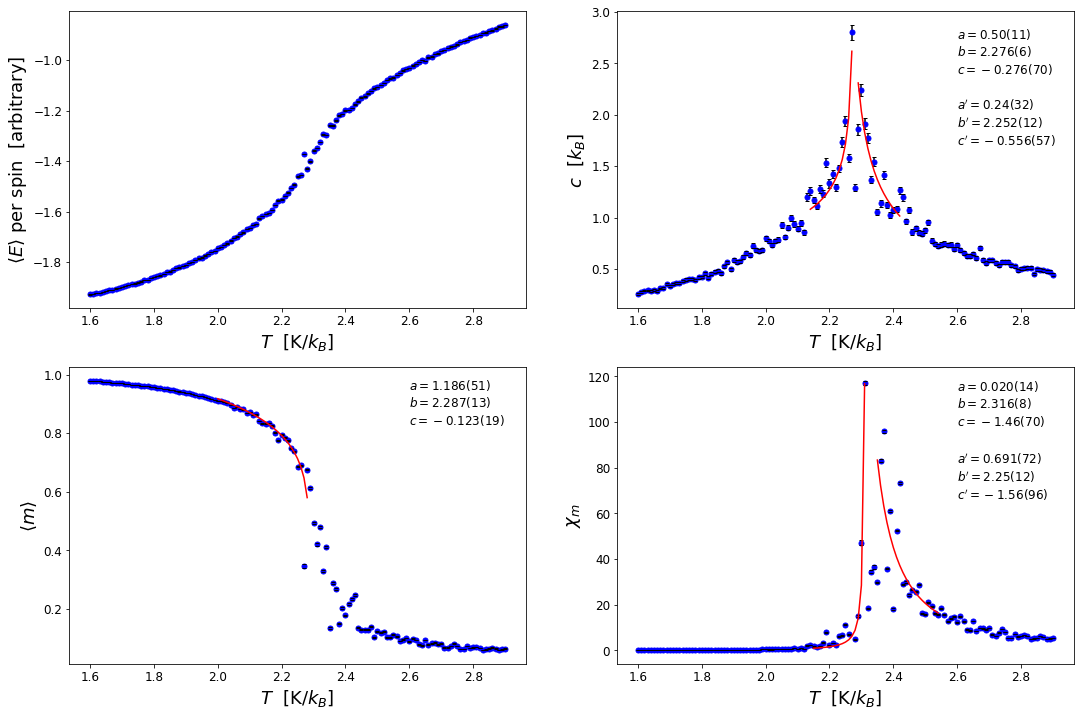

In [26]:
fig = plt.figure(figsize=(18, 12))
plt.tight_layout(pad=0, w_pad= 2, h_pad= 2)

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list, 'bo', markersize = 5)
plt.errorbar(temps, eneps_list, yerr = ene_errors, ecolor = 'black',capsize = 2, linestyle = 'None')
plt.xlabel(r"$T$  [K/$k_B$]", fontsize=18)
plt.ylabel(r"$\langle E \rangle$ per spin  [arbitrary]", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize = 12)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat, 'bo', markersize = 5)
plt.errorbar(temps, spec_heat, yerr = sh_errors, ecolor = 'black',capsize = 2, linestyle = 'None')
plt.plot(temps[54:68], f_sh, 'r')           # the line below the critical temp
plt.plot(temps[69:83], f_shp, 'r')          # the line above the critical temp
plt.xlabel(r"$T$  [K/$k_B$]", fontsize=18)
plt.ylabel("$c$  [$k_B$]", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.text(2.6, 2.4,r'$a = 0.50(11)$' +'\n' + r'$ b = 2.276(6)$' + '\n' + r'$c = -0.276(70)$', fontsize=12)
plt.text(2.6, 1.7,r"$a' = 0.24(32)$" +'\n' + r"$b' = 2.252(12)$" +'\n' + "$c' = -0.556(57)$", fontsize=12)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, magps_list, 'bo', markersize = 5)
plt.errorbar(temps, magps_list, yerr = mag_errors, ecolor = 'black',capsize = 2, linestyle = 'None')
plt.plot(temps[40:69], f_m, 'r')
plt.xlabel(r"$T$  [K/$k_B$]", fontsize=18)
plt.ylabel(r"$\langle m \rangle$", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.text(2.6, 0.83, r'$a = 1.186(51)$' +'\n' + r'$ b = 2.287(13)$' + '\n' + r'$c = -0.123(19)$', fontsize=12)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus, 'bo', markersize = 5)
plt.errorbar(temps, mag_sus, yerr = sus_errors, ecolor = 'black',capsize = 2, linestyle = 'None')
plt.plot(temps[55:72], f_test[10:], 'r')
plt.plot(temps[75:95], f_testp, 'r')
plt.xlabel(r"$T$  [K/$k_B$]", fontsize=18)
plt.ylabel(r"$\chi_m$", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.text(2.6, 98.5, r'$a = 0.020(14)$' +'\n' + r'$ b = 2.316(8)$' + '\n' + r'$c = -1.46(70)$', fontsize=12)
plt.text(2.6, 66, r"$a' = 0.691(72)$" +'\n' + r"$b' = 2.25(12)$" +'\n' + "$c' = -1.56(96)$", fontsize=12)

plt.savefig('Ising Measurements.pdf', bbox_inches = 'tight')